In [12]:
import pandas as pd
# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_bupa = pd.read_csv("experiments/data/liver_disorders/bupa.data", sep=",", header=None, names = ["mcv",
"alkphos",
"sgpt",
"sgot",
"gammagt",
"drinks",
"selector"])

data_bupa= data_bupa.drop(columns=["selector"])
data_bupa["drinks"] = (data_bupa["drinks"] >= 3).astype("int")

costs_bupa = pd.read_csv("experiments/data/liver_disorders/bupa-liver.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_bupa[1] = costs_bupa[1].str.strip(",").astype(float)
costs_bupa.index = costs_bupa.index.str.strip(":")

In [13]:
costs_bupa

,1,2
0,,
mcv,7.27,5.17
alkphos,7.27,5.17
sgpt,7.27,5.17
sgot,7.27,5.17
gammagt,9.86,7.76


In [14]:
from sklearn.model_selection import train_test_split
from skpsl import ProbabilisticScoringList


X, y = data_bupa.iloc[:,:-1].to_numpy(), data_bupa.iloc[:,-1].to_numpy() 


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [15]:
import pandas as pd
import numpy as np

names = ["age",
"sex",
"on_thyroxine",
"query_on_thyroxine",
"on_antithyroid_medication",
"sick",
"pregnant",
"thyroid_surgery",
"I131_treatment",
"query_hypothyroid",
"query_hyperthyroid",
"lithium",
"goitre",
"tumor",
"hypopituitary",
"psych",
"TSH",
"T3",
"TT4",
"T4U","FTI","class"]

# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_thyroid_train = pd.read_csv("experiments/data/thyroid/ann-train.data", sep="\ ", header=None, names=names)
data_thyroid_test = pd.read_csv("experiments/data/thyroid/ann-test.data", sep="\ ", header=None, names=names)

# remove hypothyroid patients
data_thyroid_train = data_thyroid_train[data_thyroid_train["class"] > 1]
data_thyroid_test = data_thyroid_test[data_thyroid_test["class"] > 1] 

# drop FTI as in original paper by Turney
data_thyroid_train = data_thyroid_train.drop(columns="FTI")
data_thyroid_test = data_thyroid_test.drop(columns="FTI")

X_train, y_train = data_thyroid_train.iloc[:,:-1].to_numpy(), data_thyroid_train.iloc[:,-1].to_numpy()
X_test, y_test = data_thyroid_test.iloc[:,:-1].to_numpy(), data_thyroid_test.iloc[:,-1].to_numpy()

# convert y to 0,1 where 0 is normal and 1 hyperthyroid
y_train, y_test = 1 - (y_train -2), 1 - (y_test - 2)

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Separate the majority and minority classes
X_majority = X[y == 0]
X_minority = X[y == 1]

y_majority = y[y == 0]
y_minority = y[y == 1]

# Check original class distribution
print(f"Original class distribution: Class 0 = {len(y_majority)}, Class 1 = {len(y_minority)}")

# Randomly downsample the majority class to match the minority class size
np.random.seed(42)  # For reproducibility
majority_indices = np.random.choice(len(X_majority), size=len(X_minority), replace=False)

X_majority_downsampled = X_majority[majority_indices]
y_majority_downsampled = y_majority[majority_indices]

# Combine the downsampled majority class with the minority class
X_resampled = np.vstack((X_majority_downsampled, X_minority))
y_resampled = np.hstack((y_majority_downsampled, y_minority))

# Shuffle the combined dataset (to avoid any order bias)
shuffle_indices = np.random.permutation(len(y_resampled))
X = X_resampled[shuffle_indices]
# X = X[:,16].reshape(-1,1)
y = y_resampled[shuffle_indices]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

Original class distribution: Class 0 = 6666, Class 1 = 368


/tmp/ipykernel_281377/4010213875.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_train = pd.read_csv("experiments/data/thyroid/ann-train.data", sep="\ ", header=None, names=names)
/tmp/ipykernel_281377/4010213875.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_thyroid_test = pd.read_csv("experiments/data/thyroid/ann-test.data", sep="\ ", header=None, names=names)


In [16]:
costs_thyroid = pd.read_csv("experiments/data/thyroid/ann-thyroid.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_thyroid[1] = costs_thyroid[1].str.strip(",").astype(float)
X

array([[0.56 , 1.   , 0.   , ..., 0.022, 0.074, 0.086],
       [0.28 , 1.   , 0.   , ..., 0.017, 0.074, 0.073],
       [0.58 , 0.   , 0.   , ..., 0.016, 0.082, 0.108],
       ...,
       [0.66 , 1.   , 0.   , ..., 0.017, 0.127, 0.097],
       [0.54 , 0.   , 0.   , ..., 0.008, 0.077, 0.082],
       [0.52 , 1.   , 0.   , ..., 0.028, 0.124, 0.116]])

In [17]:
from experiments.util import DataLoader
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

score_set = {-3,-2,-1,1,2,3}

# X, y = DataLoader("experiments/data/").load("thorax")
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=1 / 3, random_state=1
# )


In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion="entropy", max_depth=1).fit(X_train, y_train)

In [38]:
psl = ProbabilisticScoringList(score_set=score_set, method="brute").fit(X_train,y_train)

In [22]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

def get_bupa_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            if i == 0:
                cost += costs_bupa.iloc[s,0]
            else:
                cost += costs_bupa.iloc[s,1]
        return cost
    else:
        raise TypeError("Alarm")

def get_thyroid_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    group_a = [16,17,18,19]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            discount = False
            if s in group_a:
                if discount:
                    cost += costs_thyroid.iloc[s,1]
                else:
                    cost += costs_thyroid.iloc[s,0]
            else:
                cost += 1
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_thyroid_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

In [23]:
import numpy as np

def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf

            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists


In [24]:
briers_psl = []
briers_dt = []

accs_psl = []
accs_dt = []

baccs_psl = []
baccs_dt = []

costs_psl = []
costs_dt = []

from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss

num_features = X_train.shape[1]


for i in range(0,num_features):
    y_prob_psl = psl.predict_proba(X_test, k=i)

    print(psl[i].features)
    psl_cost = len(X_test) * get_thyroid_cost_for_feature_subset(psl[i].features) 
    print("psl:", psl[i].features)
    print(len(X_test))
    y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)

    dt_cost = 0

    for feature_subset in used_features:
        dt_cost += get_thyroid_cost_for_feature_subset(feature_subset)

    print("dt:", len(used_features), used_features)

    briers_psl.append(brier_score_loss(y_test, y_prob_psl[:,1]))
    briers_dt.append(brier_score_loss(y_test, y_prob_dt[:,1]))

    accs_psl.append(accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    accs_dt.append(accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    baccs_psl.append(balanced_accuracy_score(y_test, np.argmax(y_prob_psl,axis=1)))
    baccs_dt.append(balanced_accuracy_score(y_test, np.argmax(y_prob_dt,axis=1)))

    costs_psl.append(psl_cost)
    costs_dt.append(dt_cost)


[]
psl: []
246
dt: 246 [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

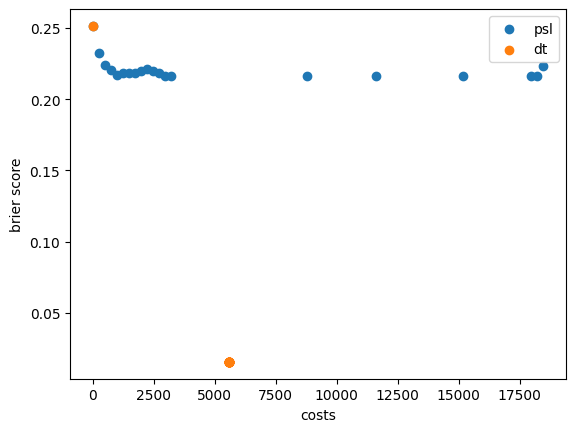

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.scatter(costs_psl, briers_psl, label="psl")
plt.scatter(costs_dt, briers_dt, label="dt")

plt.xlabel("costs")
plt.ylabel("brier score")

# plt.plot(np.arange(num_features), briers_psl, label="psl")
# plt.plot(np.arange(num_features), briers_dt, label="dt")

plt.legend()
plt.show()

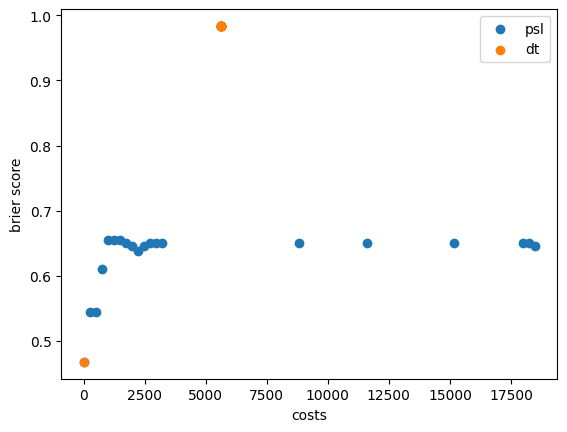

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.scatter(costs_psl, accs_psl, label="psl")
plt.scatter(costs_dt, accs_dt, label="dt")

plt.xlabel("costs")
plt.ylabel("brier score")

plt.legend()
plt.show()

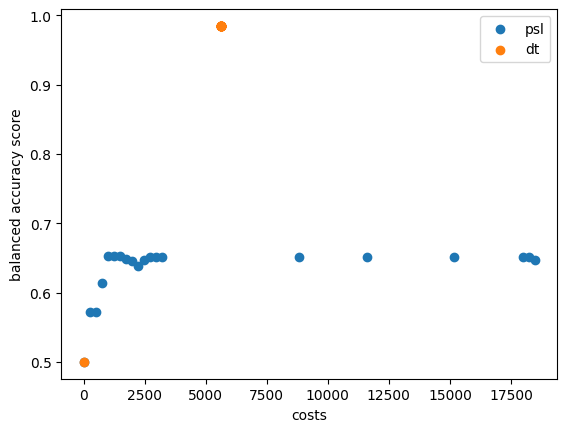

In [27]:
plt.scatter(costs_psl, baccs_psl, label="psl")
plt.scatter(costs_dt, baccs_dt, label="dt")

plt.xlabel("costs")
plt.ylabel("balanced accuracy score")

plt.legend()
plt.show()

In [28]:
y_train

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,

In [29]:
y_test

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0])

[Text(0.5, 0.75, 'x[16] <= 0.006\nentropy = 0.999\nsamples = 490\nvalue = [237, 253]'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 231\nvalue = [231, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'entropy = 0.159\nsamples = 259\nvalue = [6, 253]'),
 Text(0.625, 0.5, '  False')]

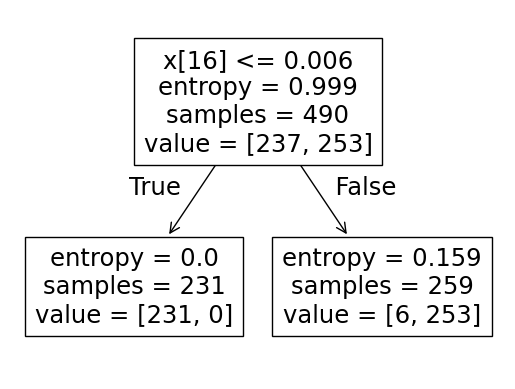

In [30]:
from sklearn.tree import plot_tree
plot_tree(dt)

In [31]:
for k, pss in enumerate(psl):
    print(f"stage: {k} expected entropy {pss.score(X_train, y_train)}")

stage: 0 expected entropy 0.9992307463769627
stage: 1 expected entropy 0.924903812452433
stage: 2 expected entropy 0.9110358764889813
stage: 3 expected entropy 0.9069837676634265
stage: 4 expected entropy 0.9013433281621767
stage: 5 expected entropy 0.8992315319640781
stage: 6 expected entropy 0.8974857883880947
stage: 7 expected entropy 0.8963539155769946
stage: 8 expected entropy 0.894350313544541
stage: 9 expected entropy 0.8936922102859945
stage: 10 expected entropy 0.8928307040757459
stage: 11 expected entropy 0.8928307040757459
stage: 12 expected entropy 0.8928307040757459
stage: 13 expected entropy 0.8928307040757459
stage: 14 expected entropy 0.8928307040757459
stage: 15 expected entropy 0.8928307040757459
stage: 16 expected entropy 0.8928307040757459
stage: 17 expected entropy 0.8928307040757459
stage: 18 expected entropy 0.8928307040757459
stage: 19 expected entropy 0.8933859214660582
stage: 20 expected entropy 0.896773417325019


In [37]:
psl.inspect(k=10)

,Stage,Feature Index,Score,T = -5,T = -4,T = -3,T = -2,T = -1,T = 0,T = 1,...,T = 4,T = 5,T = 6,T = 7,T = 8,T = 9,T = 10,T = 11,T = 12,T = 13
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516327,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,-3.0,NaN,NaN,0.0,NaN,NaN,0.553611,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,9.0,2.0,NaN,NaN,0.0,NaN,0.000000,0.530414,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.0,1.0,NaN,NaN,0.0,0.0,0.000000,0.450980,0.573077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.0,-1.0,NaN,0.0,0.0,0.0,0.325000,0.495146,0.609467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,13.0,2.0,NaN,0.0,0.0,0.0,0.325000,0.487437,0.609467,...,0.8,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,4.0,3.0,NaN,0.0,0.0,0.0,0.325000,0.487310,0.604790,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
7,7,8.0,-1.0,0.0,0.0,0.0,0.0,0.333333,0.487310,0.611111,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
8,8,10.0,1.0,0.0,0.0,0.0,0.0,0.325000,0.476684,0.614907,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
9,9,5.0,2.0,0.0,0.0,0.0,0.0,0.325000,0.475936,0.623377,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
